# Informartion storage and diagrams

## Что мы делаем?

Попробуем проанализировать насколько info storage и расстояния между диаграммами устойчивости описывают "сложность" той или иной задачи.

Так как мы ничего не можем сказать про нормальность данных и выборки достаточно маленьие, будем использовать для оценки связи тест ранговой корреляции Спирмена

Напомним структуру наши данных, мы имеем N людей у которых измеряли мозговую активность во время выполнения различных задач. Будем считать, что каждый такой человек порождает новую выборку, которая состоит из коэффициентов активности, которые каким то образом упорядочены относительно задач. Например, пусть для какого-то человека имеем следующие результаты:


| Type | Coefficient  |
| --- | --- |
| REST1 | 0.1 | 
| REST2 | 0.2 |
| EMOTION | 0.25 |
| GAMBLING | 0.2 |
| LANGUAGE | 0.3|
| RELATIONAL| 0.32|
| MOTOR| 0.4 |
|SOCIAL| 0.37|

Тогда выборкой для этого человека будет: [0.1, 0.2, 0.25, 0.2, 0.3, 0.32, 0.4, 0.37]

[Коэффициент ранговой корреляции Спирмена](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D0%BE%D1%8D%D1%84%D1%84%D0%B8%D1%86%D0%B8%D0%B5%D0%BD%D1%82_%D0%BA%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D0%B8_%D0%A1%D0%BF%D0%B8%D1%80%D0%BC%D0%B5%D0%BD%D0%B0) вычисляет разницу между рангами парой выборок. Например, если ранги у двух выборок в точности совпадают, тогда значение коэффициента равно единице. 

Отсюда также следует, что коэффициент инвариантен относительно любых монотонных преобразований, а также одинаковых перестановок пар выборок

Приведем несколько простых примеров, чтобы убедиться, что усреднение коэффициента даст что то хорошее:


In [11]:
import numpy as np
from scipy import stats

Средняя ранговая корреляция выборок из 100 случайных векторов

In [4]:
corr = []
obj = []
for _ in range(100):
    obj.append(np.random.rand(10))
    
for i in range(100):
    for j in range(i):
        res = stats.spearmanr(obj[i], obj[j])
        corr.append(res.statistic)
        
print(sum(corr) / len(corr) )

-0.00011019283746555744


Средняя ранговая корреляция, если данные одинаковые с небольшим шумом:

In [15]:
corr = []
obj = []
base = 10*np.random.rand(10)
for _ in range(100):
    obj.append(base + np.random.rand(10))
    
for i in range(100):
    for j in range(i):
        res = stats.spearmanr(obj[i], obj[j])
        corr.append(res.statistic)
        
print(sum(corr) / len(corr) )

0.969349250076547


С большим шумом

0.52338414447505


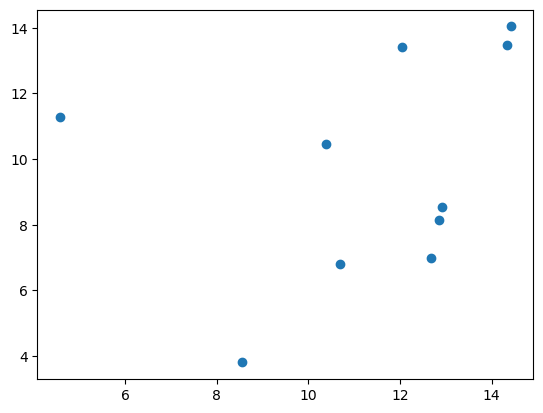

In [18]:
corr = []
obj = []
base = 10* np.random.rand(10)
for _ in range(100):
    obj.append(base + 10*np.random.rand(10))
    
for i in range(100):
    for j in range(i):
        res = stats.spearmanr(obj[i], obj[j])
        corr.append(res.statistic)
        
print(sum(corr) / len(corr) )

import matplotlib.pyplot as plt
import numpy as np

plt.scatter(obj[0], obj[1])
plt.show()

Если считать коэффициент корреляции между парой объектов случайной величиной, которая завичит от двух выборок, то по ЗБЧ выборочное среднее будем стреиться к средней корреляции

## Адекватность использования info storage как меры активности мозга

Применим предложенный выше подход и посчитаем корреляции

In [30]:
import glob
obj_all = glob.glob('*', recursive=True,  dir_fd='info_storage')

# Множество всех объектов
obj= set()
for fname in obj_all:
    obj.add(fname[0:6])

In [148]:
import os
data =[]

types = []
all_res = []
for obj_id in obj:
    obj_data = []
    files = glob.glob(f'{obj_id}*', recursive=True, dir_fd='info_storage')
    for file in files:
        try:
            info_storage = np.load(os.getcwd() + "\\info_storage\\" + file)
        except ValueError:
            continue
        s = np.sum(info_storage) * 10000
        obj_data.append([s, file, file.split('_')[-2]])

    obj_data = sorted(obj_data, key = lambda x: x[2])

    data.append(obj_data)
    


In [149]:
data = [x for x in data if len(x) == 9]
data_info_storage = data
print(len(data))

137


В списке data хранятся вычисленные коэффициенты для всех объектов, для которых нашли 9 типов активностей

In [62]:
data_coeff = []
for elem in data:
    data_coeff.append([x[0] for x in elem])

In [63]:
corr = []
for i in range(len(data_coeff)):
    for j in range(i):
        res = stats.spearmanr(data_coeff[i], data_coeff[j])
        corr.append(res.statistic)
            
np.mean(corr)

0.4963342636324603

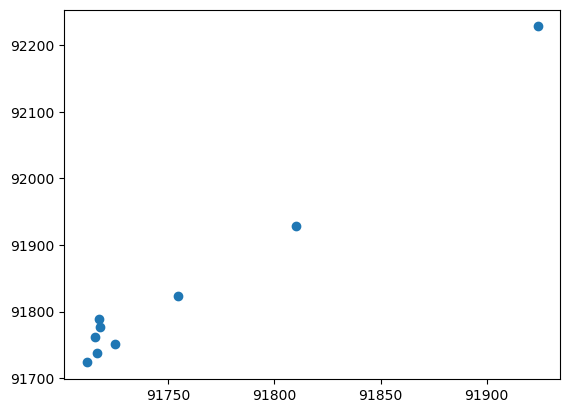

In [71]:
plt.scatter(data_coeff[0], data_coeff[3])
plt.show()

Посмотрим также на распределения коэффициентов для одинаковых активностей

In [74]:
types = [x[2] for x in data[0]]
scores = {x : [] for x in types}

for elem in data:
    for obs in elem:
        scores[obs[2]].append(obs[0])
    

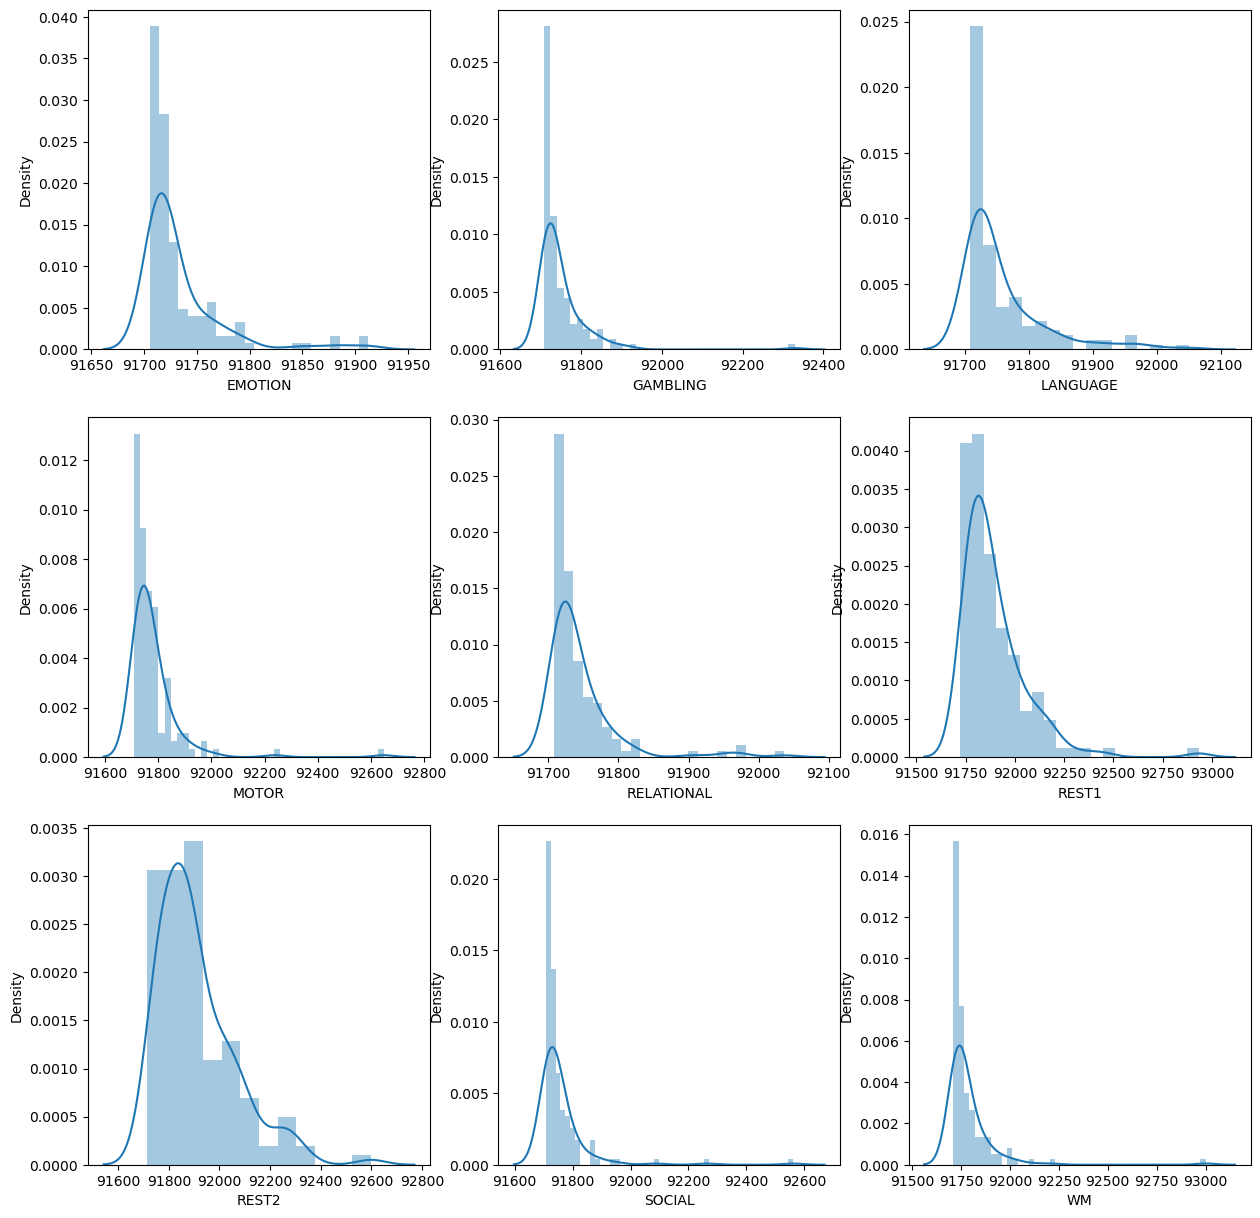

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame.from_dict(scores,orient='index').transpose()

fig, axes = plt.subplots(nrows=3 , ncols=3, figsize=(15,15))
for i, column in enumerate(df.columns):
    sns.distplot(df[column],ax=axes[i//3,i%3])
plt.show()

In [94]:
means = [(np.mean(score) , key) for key, score in scores.items()]

In [101]:
for row in sorted(means):
    print(row)

(91733.63073028787, 'EMOTION')
(91744.51424257598, 'RELATIONAL')
(91749.24335340514, 'GAMBLING')
(91757.65169798023, 'LANGUAGE')
(91758.55079706568, 'SOCIAL')
(91779.65992558612, 'MOTOR')
(91784.77934677235, 'WM')
(91895.11507967093, 'REST1')
(91909.17913060989, 'REST2')


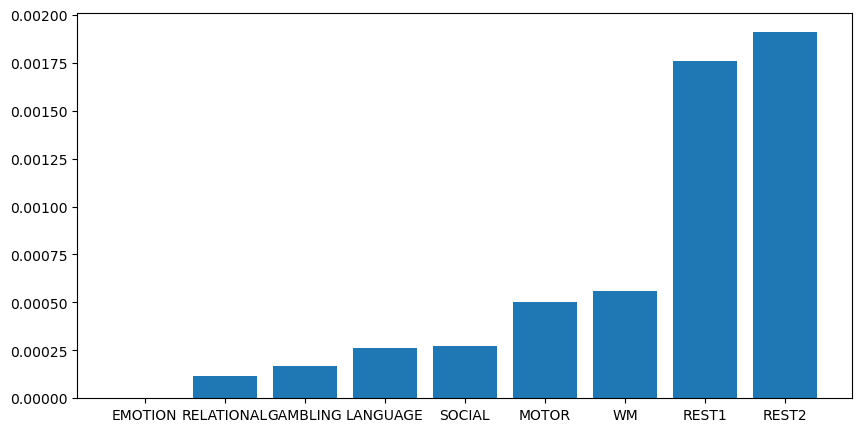

In [109]:

sorted_means = sorted(means)


types = [x[1] for x in sorted_means]
score = [x[0] for x in sorted_means] 
score = [x / np.mean(score) for x in score]
score = [x - min(score) for x in score]
fig = plt.figure(figsize = (10, 5))


plt.bar(types, score)
 

plt.show()

# Проверка адекватности растояний между диаграмами

Проделаем тоже самое но в качестве расстояния возьмем расстояние дл диаграммы REST1

In [113]:
import glob
import numpy as np
import glob
import gtda
from gtda import diagrams
obj_all = glob.glob('*', recursive=True,  dir_fd='persistence_dgms')

# Множество всех объектов
obj= set()
for fname in obj_all:
    obj.add(fname[0:6])

In [137]:
import os
data =[]

types = []
all_res = []
for obj_id in obj:
    obj_data = []
    obj_data_raw = []
    files = glob.glob(f'{obj_id}*', recursive=True, dir_fd='persistence_dgms')
    if len(files) != 9:
        continue
    for file in files:
        try:
            diagram = np.load(os.getcwd() + "\\persistence_dgms\\" + file)
        except ValueError:
            continue
            
        if 'REST1' in file:
            base_diagram = diagram
        obj_data_raw.append([diagram, file, file.split('_')[-2]])
    distance = diagrams.distance.PairwiseDistance()
    distance.fit(base_diagram[None, :, :])
    
    obj_data = [(distance.transform((x[None, :, :]))[0][0], name, typ) for x, name, typ in obj_data_raw]
    obj_data = sorted(obj_data, key = lambda x: x[2])
    data.append(obj_data)
    
data_diagrams = data

In [128]:
data = [x for x in data if len(x) == 9]
print(len(data))

data_coeff = []
for elem in data:
    data_coeff.append([x[0] for x in elem])

137


In [129]:
data_coeff[0][0]

0.11620385946746926

In [130]:
corr = []
for i in range(len(data_coeff)):
    for j in range(i):
        res = stats.spearmanr(data_coeff[i], data_coeff[j])
        corr.append(res.statistic)
            
np.mean(corr)

0.6041809789609275

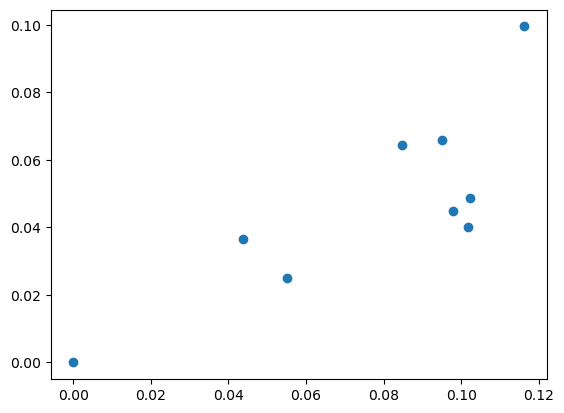

In [131]:
plt.scatter(data_coeff[0], data_coeff[3])
plt.show()

In [132]:
types = [x[2] for x in data[0]]
scores = {x : [] for x in types}

for elem in data:
    for obs in elem:
        scores[obs[2]].append(obs[0])

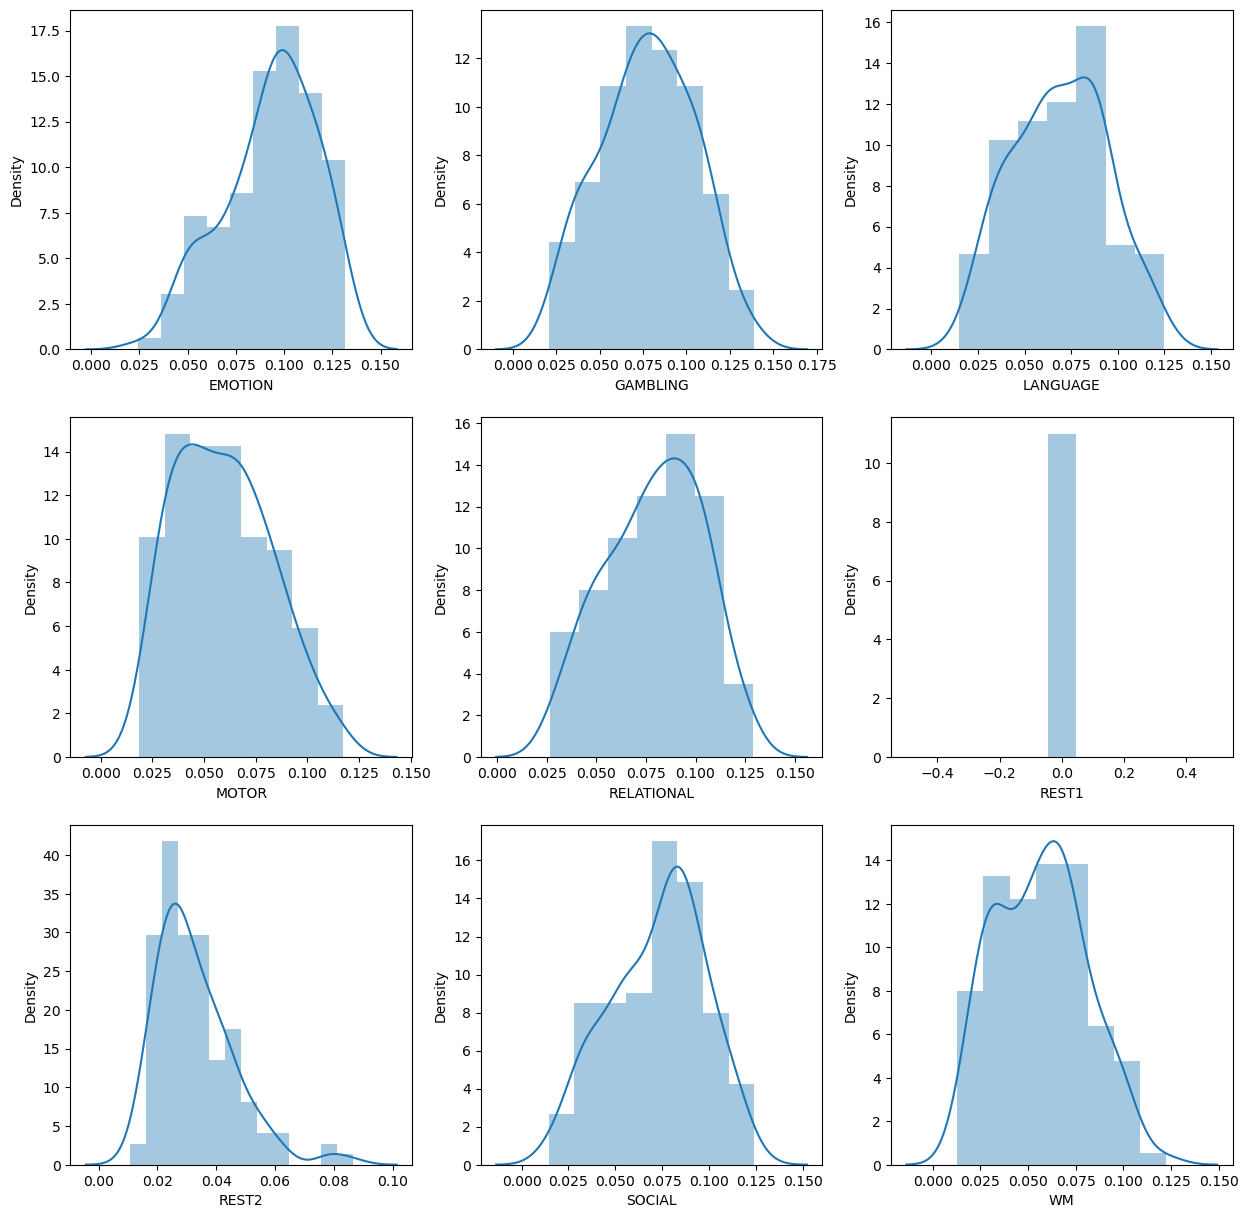

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.DataFrame.from_dict(scores,orient='index').transpose()

fig, axes = plt.subplots(nrows=3 , ncols=3, figsize=(15,15))
for i, column in enumerate(df.columns):
    sns.distplot(df[column],ax=axes[i//3,i%3])
plt.show()

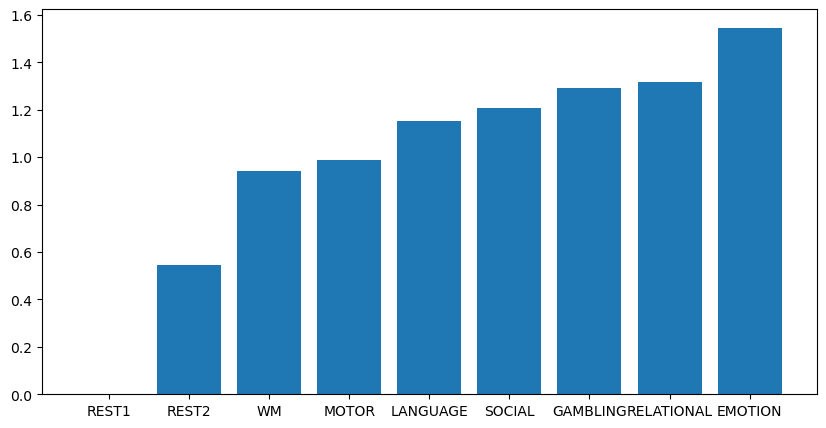

In [135]:
means = [(np.mean(score) , key) for key, score in scores.items()]
sorted_means = sorted(means)


types = [x[1] for x in sorted_means]
score = [x[0] for x in sorted_means] 
score = [x / np.mean(score) for x in score]
score = [x - min(score) for x in score]
fig = plt.figure(figsize = (10, 5))


plt.bar(types, score)
 

plt.show()

С точностью до изменения порядка, получилось почти такое же ранжирование средних.

## Кореляция между диаграмами и info_storage

In [152]:
corr = []
for res1, res2 in zip(data_info_storage, data_diagrams):
    scores1 = [x[0] for x in res1]
    scores2 = [x[0] for x in res2]
    correlation = stats.spearmanr(scores1, scores2)
    corr.append(correlation.statistic)
    
print(np.mean(corr))

-0.8498783454987835


Получиил буквально то, чего желали, с точностью до изменения порядка